In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS
import sklearn.model_selection as skm
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path)

Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()
Hitters = Hitters.dropna();

design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary']).reshape(-1,1)
X = design.transform(Hitters)

Y.shape

(263, 1)

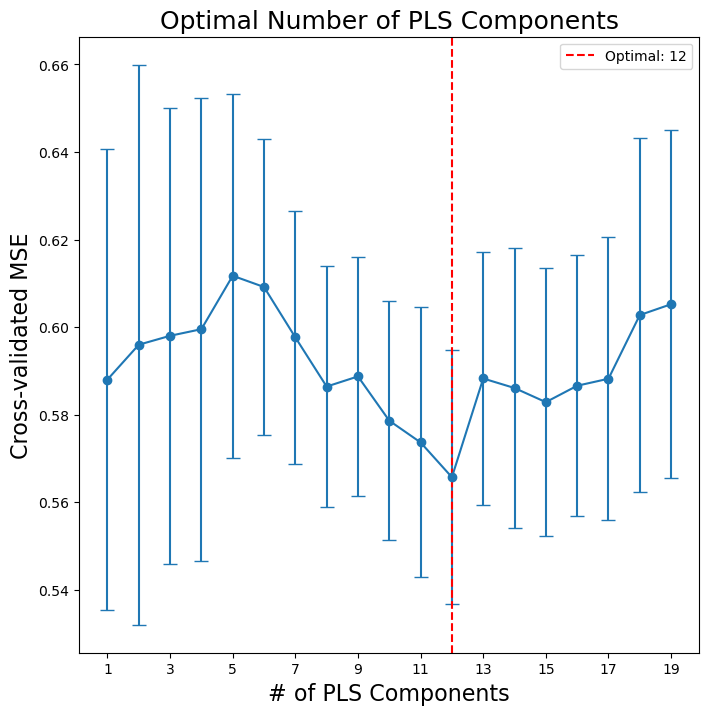

In [3]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)#

K = 5
kfold = skm.KFold(K,
random_state=0,
shuffle=True)

pls = PLSRegression()

param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls ,
param_grid ,
cv=kfold,
scoring='neg_mean_squared_error')
grid.fit(X_scaled, Y_scaled)

# Extract results
mean_mse = -grid.cv_results_['mean_test_score']
std_mse = grid.cv_results_['std_test_score'] / np.sqrt(K)
optimal_n_components = grid.best_params_['n_components']

# Plot Cross-Validated MSE vs. # of PLS Components
plt.figure(figsize=(8, 8))
plt.errorbar(param_grid['n_components'], mean_mse, yerr=std_mse, fmt='o-', capsize=5)
plt.axvline(optimal_n_components, color='r', linestyle='--', label=f'Optimal: {optimal_n_components}')
plt.ylabel("Cross-validated MSE", fontsize=16)
plt.xlabel("# of PLS Components", fontsize=16)
plt.xticks(list(param_grid['n_components'])[::2])  # Show every other tick
plt.title("Optimal Number of PLS Components", fontsize=18)
plt.legend()
plt.show()




1.0
0.5399655850217974


c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


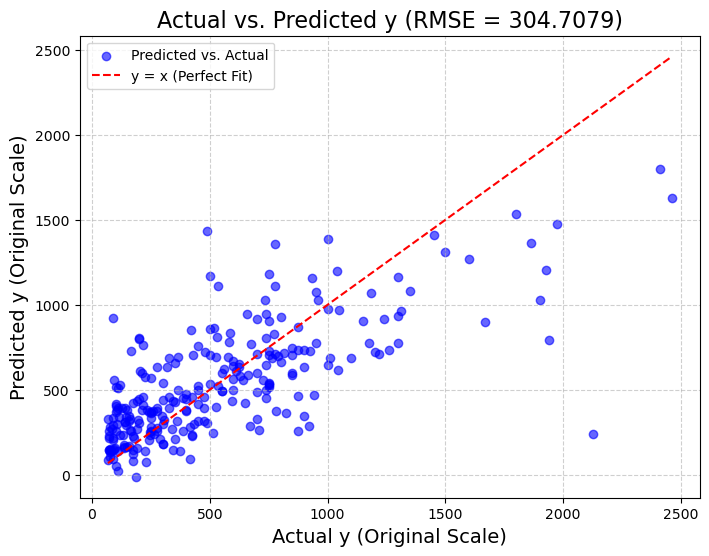

RMSE (Original Scale): 304.7079
R2_X (Explained Variance in X): 0.7613
R2_Y (Explained Variance in Y): 0.5400


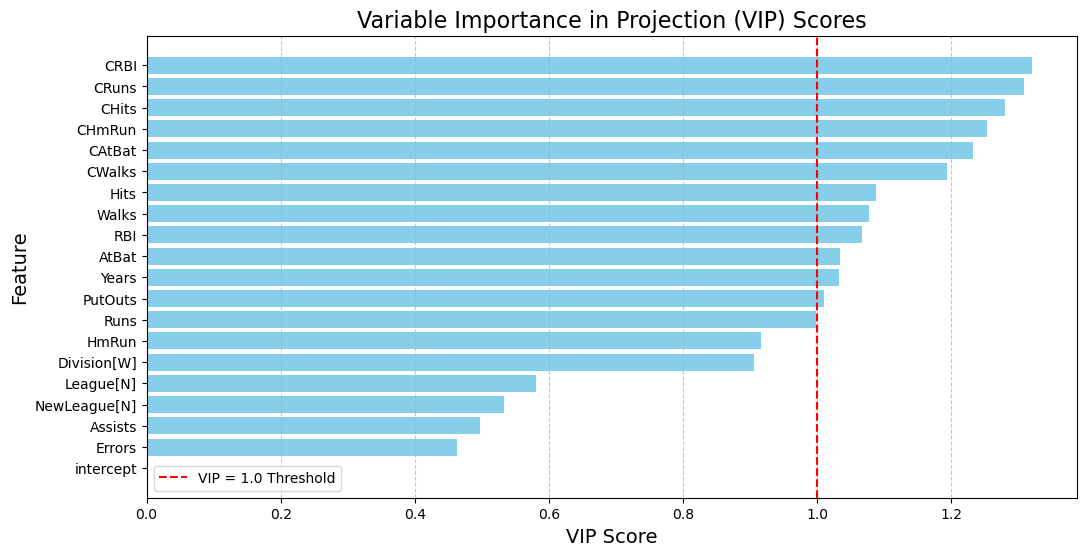

In [5]:
pls_final = PLSRegression(n_components=12)
pls_final.fit(X_scaled, Y_scaled)
y_pred = pls_final.predict(X_scaled)  # Predictions in standardized form
y_pred_original = scaler_y.inverse_transform(y_pred)  # Convert back

# Compute RMSE in original scale
rmse_original = mean_squared_error(Y, y_pred_original, squared=False)

# Compute R2_X (explained variance in X)
R2_X = np.var(pls_final.x_scores_, axis=0).sum() / np.var(X_scaled, axis=0).sum()

# Compute R2_Y (explained variance in Y)
total_variance_y = np.var(Y_scaled)
print(total_variance_y)
variance_explained_y = np.sum((pls_final.y_loadings_ ** 2) * np.var(pls_final.x_scores_, axis=0))
print(variance_explained_y)

R2_Y = variance_explained_y / total_variance_y

# Plot actual vs. predicted y values
plt.figure(figsize=(8, 6))
plt.scatter(Y, y_pred_original, alpha=0.6, color="blue", label="Predicted vs. Actual")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle="--", label="y = x (Perfect Fit)")
plt.xlabel("Actual y (Original Scale)", fontsize=14)
plt.ylabel("Predicted y (Original Scale)", fontsize=14)
plt.title(f"Actual vs. Predicted y (RMSE = {rmse_original:.4f})", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print performance metrics
print(f"RMSE (Original Scale): {rmse_original:.4f}")
print(f"R2_X (Explained Variance in X): {R2_X:.4f}")
print(f"R2_Y (Explained Variance in Y): {R2_Y:.4f}")

def calculate_vip(pls, X):
    """
    Compute Variable Importance in Projection (VIP) scores for PLSRegression.

    Parameters:
    - pls: Trained PLSRegression model
    - X: The original feature matrix (before scaling)

    Returns:
    - vip_scores: Array of VIP scores for each feature
    """
    t = pls.x_scores_  # PLS scores
    w = pls.x_weights_  # PLS weights
    q = pls.y_loadings_  # PLS loadings for y

    p, A = w.shape  # Number of variables (p) and components (A)

    s = np.var(t, axis=0) * (q**2).flatten()  # Variance explained per component
    total_s = np.sum(s)  # Total variance explained

    vip = np.sqrt(p * np.sum((w**2) * s.reshape(1, -1), axis=1) / total_s)
    return vip  # Convert to 1D array

    
# Compute VIP scores for the trained PLS model
vip_scores = calculate_vip(pls_final, X_scaled)

# Create a DataFrame with variable importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "VIP Score": vip_scores
}).sort_values(by="VIP Score", ascending=False)

# Create a DataFrame with variable importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "VIP Score": vip_scores
}).sort_values(by="VIP Score", ascending=False)

# Plot VIP scores
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["VIP Score"], color="skyblue")
plt.axvline(1.0, color='r', linestyle='--', label="VIP = 1.0 Threshold")
plt.xlabel("VIP Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Variable Importance in Projection (VIP) Scores", fontsize=16)
plt.gca().invert_yaxis()  # Flip the highest values to the top
plt.legend()
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()
